In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
import sys,os
import sqlite3
from dateutil import parser

In [2]:
# connect to DB
SRC_DIR = os.path.dirname(os.getcwd())
dbname = "quickbooks.db"
dbpath = os.path.join(SRC_DIR,"db",dbname)
conn = sqlite3.connect(dbpath) 
alldf = pd.read_sql("select * from categorized_items", conn, parse_dates=['Date'])

In [3]:
alldf.to_csv('categorized_items.csv')

In [4]:
budget_file = os.path.join(SRC_DIR,'config','qb_to_budget_map.csv')
budgetdf = pd.read_csv(budget_file)

In [64]:
# Date information
year = 2024
month = 5 # month number (i.e. 4 for April)
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]

In [65]:
print(f"Grabbing report details for {month_name}")
interval = (f"{year}-{month}-01",f"{year}-{month}-{days}")
interval_dates = (parser.parse(interval[0]),parser.parse(interval[1]))
qbdf = alldf.loc[(alldf['Date']>=interval_dates[0]) & (alldf['Date']<interval_dates[1])]

Grabbing report details for May


In [66]:
# data manipulation
budgetdf['Budget'] = budgetdf['Budget']
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [67]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum","Date":'count'}).reset_index()
item_totals.columns = ['item','Amount','Transactions']
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [68]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

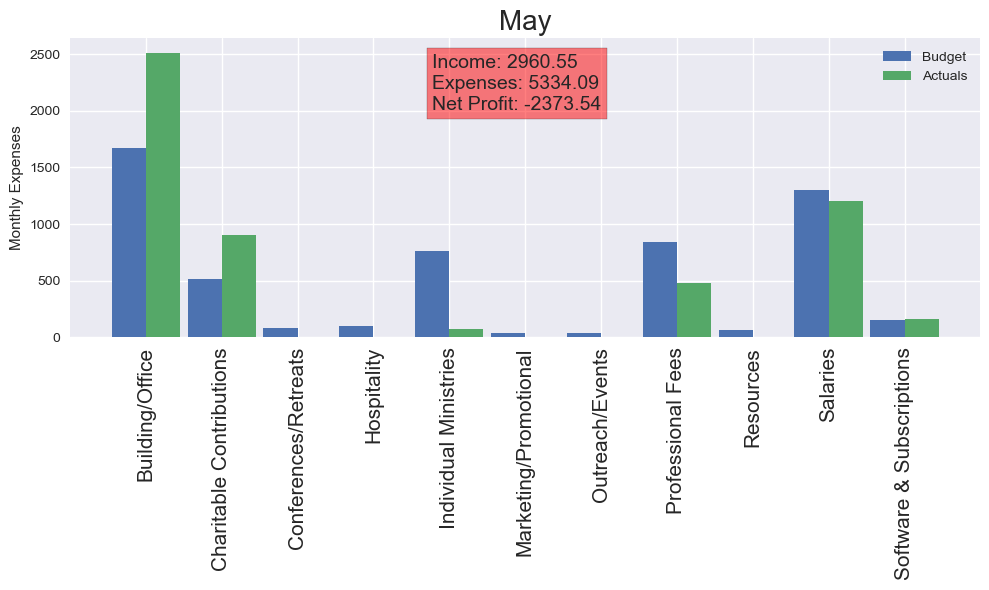

In [69]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [70]:
report_totals = all_totals[~all_totals['item'].isin(['Lead Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Item', 'Budget', 'Amount', 'Transactions']]
report_totals = report_totals.replace(np.NAN,0)
report_totals['Transactions'] = report_totals['Transactions'].astype(int)

In [71]:
report_totals

,Item,Budget,Amount,Transactions
7,Building Repair/Maintenance,1000.0,1157.45,5
11,Church Insurance,377.5,1118.00,1
13,Utilities,462.5,305.42,1
36,Life Network,129.0,300.00,1
37,Joel Frees,129.0,300.00,1
38,Crossfire,129.0,300.00,1
16,Lawn/Snow Service,125.0,176.37,3
21,Software & Subscriptions,156.0,162.69,7
3,Office Supplies,42.0,125.62,1
9,Trash,23.0,113.85,1


In [72]:
all_totals.sort_values("Amount", ascending=False)

,Category,Subcategory,Item,QB_Item,Budget,item,Amount,Transactions
0,Salaries,Salaries,Lead Pastor,Lead Pastor,1300.00,Lead Pastor,1200.00,4.0
7,Facilities,Building/Office,Building Repair/Maintenance,Repair and Maintenance,1000.00,Repair and Maintenance,1157.45,5.0
11,Facilities,Building/Office,Church Insurance,Church Insurance,377.50,Church Insurance,1118.00,1.0
13,Facilities,Professional Fees,Utilities,Utilities,462.50,Utilities,305.42,1.0
36,Giving,Charitable Contributions,Life Network,Life Network,129.00,Life Network,300.00,1.0
37,Giving,Charitable Contributions,Joel Frees,Joel Frees,129.00,Joel Frees,300.00,1.0
38,Giving,Charitable Contributions,Crossfire,Crossfire,129.00,Crossfire,300.00,1.0
16,Facilities,Professional Fees,Lawn/Snow Service,Lawn/Snow,125.00,Lawn/Snow,176.37,3.0
21,Facilities,Software & Subscriptions,Software & Subscriptions,Software and Subscriptions,156.00,Software and Subscriptions,162.69,7.0
3,Facilities,Building/Office,Office Supplies,Office Supplies,42.00,Office Supplies,125.62,1.0


In [73]:
special_account = qbdf[qbdf['item']=='Worship Contribution']

In [77]:
expenses.loc[expenses['item']=='Repair and Maintenance']

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item,Account_Type
178,2024-05-02,Expense,,,Sprinkler service. Wirenut,1002 ENT Checking (Keystone),794.20,794.20,Expenses:Facilities:Building/Office:Repair and...,4,Repair and Maintenance,Expenses
179,2024-05-03,Check,375,McCarthy Plumbing,Sewer line flush,1002 ENT Checking (Keystone),100.00,894.20,Expenses:Facilities:Building/Office:Repair and...,4,Repair and Maintenance,Expenses
180,2024-05-10,Expense,,Lowe's,"LOWE'S #1099 COLORADO SPGS C POS, Withdrawal, ...",1002 ENT Checking (Keystone),109.69,1003.89,Expenses:Facilities:Building/Office:Repair and...,4,Repair and Maintenance,Expenses
181,2024-05-15,Expense,,,"Visa Check CIRCLE ACE HARDWARE DebitCard, Wit...",1002 ENT Checking (Keystone),116.79,1120.68,Expenses:Facilities:Building/Office:Repair and...,4,Repair and Maintenance,Expenses
182,2024-05-17,Expense,,,Window well covers (reimbursed),1002 ENT Checking (Keystone),36.77,1157.45,Expenses:Facilities:Building/Office:Repair and...,4,Repair and Maintenance,Expenses
